#Getting the data and packages

## Installing the relevant packages
You can install packages just like how normally you install packages on device,
Make sure you include `!` before the `pip install` command

In [1]:
!pip install -U scikit-learn scipy numpy pandas xgboost ost scikit-optimize imbalanced-learn geopy swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score, recall_score
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split, cross_val_predict, HalvingGridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.metrics import classification_report
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
from geopy.geocoders import Nominatim
import swifter
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
import csv
from matplotlib import pyplot

# 1.1 Feature Selection

In [3]:
#read data
train = pd.read_excel("./cases_2021_train_processed_2.xlsx")
train.head()

,age,sex,province,country,latitude,longitude,date_confirmation,chronic_disease_binary,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,outcome_group
0,18,female,Bihar,India,25.49096,85.93903,2020-05-18,False,265527,1576,262371,1580,212.762145,0.593537,hospitalized
1,27,female,NaN,Philippines,7.07000,125.60000,2020-04-15,False,747288,13297,603746,130245,681.949809,1.779368,nonhospitalized
2,46,male,Tamil Nadu,India,13.08362,80.28252,2020-05-02,False,886673,12719,858075,15879,1139.078325,1.434463,hospitalized
3,21,female,Tamil Nadu,India,13.08362,80.28252,2020-05-24,False,886673,12719,858075,15879,1139.078325,1.434463,hospitalized
4,27,male,Bihar,India,26.28361,87.20347,2020-05-27,False,265527,1576,262371,1580,212.762145,0.593537,hospitalized


In [4]:
#convert datetime to numerical 
train["date_confirmation"]=pd.to_numeric(pd.to_datetime(train["date_confirmation"]))

#make death_ratio, recovered_ratio, active_ratio
train["death_ratio"] = train["Deaths"]/train["Confirmed"]
train["recovered_ratio"] = train["Recovered"]/train["Confirmed"]
train["active_ratio"] = train["Active"]/train["Confirmed"]

#drop umwanted features
train= train.drop(["latitude","longitude","Deaths","Recovered","Active","Confirmed"], axis=1)
train.dtypes

age                         int64
sex                        object
province                   object
country                    object
date_confirmation           int64
chronic_disease_binary       bool
Incident_Rate             float64
Case_Fatality_Ratio       float64
outcome_group              object
death_ratio               float64
recovered_ratio           float64
active_ratio              float64
dtype: object

In [5]:
#funtion to inpute province
def inpute_province(row):
  if row['province'] == 0:
    return row['country']
  else:
    return row['province']

#imput province with country
train.province.fillna(0, inplace=True)
train["province"] = train.swifter.apply(inpute_province, axis=1)

Pandas Apply:   0%|          | 0/17212 [00:00<?, ?it/s]

In [6]:
# do the same thing with test data
test = pd.read_excel("./cases_2021_test_processed_unlabelled_2.xlsx")
test.shape

(4304, 14)

In [7]:
# do the same thing with test data
test["date_confirmation"]=pd.to_numeric(pd.to_datetime(test["date_confirmation"]))
test["death_ratio"] = test["Deaths"]/test["Confirmed"]
test["recovered_ratio"] = test["Recovered"]/test["Confirmed"]
test["active_ratio"] = test["Active"]/test["Confirmed"]
test= test.drop(["latitude","longitude","Deaths","Recovered","Active","Confirmed"], axis=1)
test.dtypes

age                         int64
sex                        object
province                   object
country                    object
date_confirmation           int64
chronic_disease_binary       bool
Incident_Rate             float64
Case_Fatality_Ratio       float64
death_ratio               float64
recovered_ratio           float64
active_ratio              float64
dtype: object

In [8]:
# do the same thing with test data
test.province.fillna(0, inplace=True)
test["province"] = test.swifter.apply(inpute_province, axis=1)

Pandas Apply:   0%|          | 0/4304 [00:00<?, ?it/s]

# 1.2 Mapping the Features

In [9]:
#use LabelEncoder to encode feature
lbl = preprocessing.LabelEncoder()
train['sex'] = lbl.fit_transform(train['sex'].astype(str))
train['country'] = lbl.fit_transform(train['country'].astype(str))
train['province'] = lbl.fit_transform(train['province'].astype(str))
train['outcome_group'] = lbl.fit_transform(train['outcome_group'].astype(str))
train["chronic_disease_binary"]= lbl.fit_transform(train['chronic_disease_binary'].astype(str))
train.dtypes

age                         int64
sex                         int64
province                    int64
country                     int64
date_confirmation           int64
chronic_disease_binary      int64
Incident_Rate             float64
Case_Fatality_Ratio       float64
outcome_group               int64
death_ratio               float64
recovered_ratio           float64
active_ratio              float64
dtype: object

In [10]:
# do the same thing with test data
test['sex'] = lbl.fit_transform(test['sex'].astype(str))
test['country'] = lbl.fit_transform(test['country'].astype(str))
test['province'] = lbl.fit_transform(test['province'].astype(str))
test["chronic_disease_binary"]= lbl.fit_transform(test['chronic_disease_binary'].astype(str))
test.dtypes

age                         int64
sex                         int64
province                    int64
country                     int64
date_confirmation           int64
chronic_disease_binary      int64
Incident_Rate             float64
Case_Fatality_Ratio       float64
death_ratio               float64
recovered_ratio           float64
active_ratio              float64
dtype: object

# 1.3. Balance Dataset

In [11]:
train.outcome_group.value_counts()

1    13241
2     2974
0      997
Name: outcome_group, dtype: int64

In [12]:
#get X y from training
X, y = train.drop(["outcome_group"], axis=1), train["outcome_group"].values
np.unique(y,return_counts=True)

(array([0, 1, 2]), array([  997, 13241,  2974]))

In [13]:
#use train_test_split to split training into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
np.unique(y_train,return_counts=True)

(array([0, 1, 2]), array([  771, 10592,  2406]))

In [14]:
#balance the training data using imbalance learn SMOTETomek
sm = SMOTETomek()
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
np.unique(y_resampled,return_counts=True)

(array([0, 1, 2]), array([ 9883, 10443,  9974]))

# Random Forest

In [18]:
#testing unbalance + Random Forest
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(f1_score(y_test, y_pred, average=None), f1_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred))


[0.48       0.98744142 0.86394558] 0.7771290009287064
              precision    recall  f1-score   support

           0       0.60      0.40      0.48       226
           1       0.98      0.99      0.99      2649
           2       0.84      0.89      0.86       568

    accuracy                           0.94      3443
   macro avg       0.81      0.76      0.78      3443
weighted avg       0.93      0.94      0.93      3443



In [19]:
#testing SMOTETomek + Random Forest
pipeline = Pipeline(steps=[('c', SMOTETomek()), ('m', rfc)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f1_score(y_test, y_pred, average=None), f1_score(y_test, y_pred, average="macro"))
  
print(classification_report(y_test, y_pred))



[0.47407407 0.9785782  0.81419234] 0.7556148722434384
              precision    recall  f1-score   support

           0       0.41      0.57      0.47       226
           1       0.98      0.97      0.98      2649
           2       0.87      0.77      0.81       568

    accuracy                           0.91      3443
   macro avg       0.75      0.77      0.76      3443
weighted avg       0.93      0.91      0.92      3443



## Hyperparameter Tuning (RandomForestClassifier) -- Kingsley



In [20]:
#list of hyperparameter for Random Forest
max_depth_list = [3, 4, 5, 6, 7, 8, 9, 10]
n_estimators_list = [100,200,300]
criterion_list = ["gini", "entropy", "log_loss"]
min_samples_split_list = [2, 4, 6, 8, 10, 12]
min_samples_leaf_list = [0, 1, 2, 3, 4]
max_features_list = [5,6,7,8,9,10,11,12]

In [ ]:
#Randomized Search CV
best_score = 0
best_params=[]
n_itr=100
f = open("model_1_tuning.txt", "w+")
for i in range(n_itr):
    max_d = random.choice(max_depth_list)
    n_est = random.choice(n_estimators_list)
    cri = random.choice(criterion_list)
    min_split = random.choice(min_samples_split_list)
    max_f = random.choice(max_features_list)
    
    pipeline = Pipeline(steps=[('c', SMOTETomek()), ('m', RandomForestClassifier(
        max_depth = max_d,
        n_estimators = n_est,
        criterion = cri,
        min_samples_split = min_split,
        min_samples_leaf = min_split,
        max_features = max_f,
        n_jobs=-1
        random_state=0
    ))])
    
    F1_macro_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='f1_macro')
    mean_F1_macro_scores = sum(F1_macro_scores) / len(F1_macro_scores)
    
    F1_deceased_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring= make_scorer(f1_score, labels=[0], average= "macro"))
    mean_F1_deceased_scores = sum(F1_deceased_scores) / len(F1_deceased_scores)
    
    accuracy_score = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='accuracy')
    mean_accuracy_score = sum(accuracy_score) / len(accuracy_score)
    
    if F1_macro_scores > best_score:
        best_params=[max_d, n_est, cri, min_split, max_f]
        best_score = F1_macro_scores
    
    f.write(f"========{i}========")
    f.write('\n')
    f.write(f"max_depth: {max_d}, n_estimators: {n_est}, criterion: {cri}, min_samples_split: {min_split}, max_features: {max_f}\n")
    f.write('\n')
    f.write(f"mean_F1_macro_scores={mean_F1_macro_scores},mean_F1_deceased_scores={mean_F1_deceased_scores},mean_accuracy_score={mean_accuracy_score}\n")
    f.write('\n')
    
f.write(f"Best Params: {best_params}")
f.write(f"Best Params: {best_score}")

In [21]:
best_params = {"max_depth":7,"n_estimators":100, "criterion": 'log_loss', "min_samples_split": 2, "max_features" : 5}


In [22]:
#testing best_params
pipeline = Pipeline(steps=[('c', SMOTETomek(random_state=0)),
                ('m',
                 RandomForestClassifier(n_jobs=-1,
                                        max_depth=7, 
                                        n_estimators= 100, 
                                        criterion = "log_loss", 
                                        min_samples_split= 2, 
                                        max_features= 5,
                                        random_state=0))])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f1_score(y_test, y_pred, average=None), f1_score(y_test, y_pred, average="macro"))
  
print(classification_report(y_test, y_pred))

scores = cross_val_score(pipeline, X, y, cv=10,  scoring='f1_macro', n_jobs =- 1)
print(sum(scores)/len(scores))

[0.58969072 0.9879925  0.84407096] 0.807251392892358
              precision    recall  f1-score   support

           0       0.55      0.63      0.59       226
           1       0.98      0.99      0.99      2649
           2       0.90      0.80      0.84       568

    accuracy                           0.94      3443
   macro avg       0.81      0.81      0.81      3443
weighted avg       0.94      0.94      0.94      3443

0.789715165314148


# XGboost

In [23]:
#unbalance + XGboost
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

scores = cross_val_score(xgb, X_train, y_train, cv=10, scoring='f1_macro',n_jobs=-1)
print("avaerage F1:",sum(scores)/len(scores))

NameError: ignored

In [ ]:
#SMOTETomek + XGboost
pipeline = Pipeline(steps=[('c', SMOTETomek()), ('m', xgb)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

scores = cross_val_score(pipeline, X, y, cv=10,  scoring='f1_macro', n_jobs=-1)
print("avaerage F1:",sum(scores)/len(scores))

# 1.4. Hyperparameter Tuning (XGBoost) -- Jacky

In [ ]:
#list of hyperparameter for XGBoost
learning_rate_list = [0.01,0.05,0.10,0.15,0.20]
max_depth_list = [ 3, 4, 5, 6, 7, 8, 9, 10]
min_child_weight_list= [ 1, 3, 5, 7 ]
colsample_bytree_list = [ 0.3, 0.4, 0.5 , 0.7 , 1]
n_estimators_list = [100,200,300]

In [ ]:
#Randomized Search CV for XGBoost
best_score = 0
best_params=[]
n_itr=100
f = open("model_1_tuning.txt", "w+")
for i in range(n_itr):
    lear = random.choice(learning_rate_list)
    max_d = random.choice(max_depth_list)
    min_c = random.choice(min_child_weight_list)
    cols = random.choice(colsample_bytree_list)
    n_est = random.choice(n_estimators_list)
    
    pipeline = Pipeline(steps=[('c', SMOTETomek()), ('m', XGBClassifier(
        learning_rate = lear,
        max_dept = max_d,
        min_child_weight = min_c,
        colsample_bytree = cols,
        n_estimators = n_est,
        random_state=0,
        n_jobs=-1,
        objective="multi:softprob",
        eval_metric="auc",
        verbosity=0,
    ))])
    
    
    F1_macro_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='f1_macro',n_jobs=-1)
    mean_F1_macro_scores = sum(F1_macro_scores) / len(F1_macro_scores)
    
    F1_deceased_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring= make_scorer(f1_score, labels=[0], average= "macro"),n_jobs=-1)
    mean_F1_deceased_scores = sum(F1_deceased_scores) / len(F1_deceased_scores)
    
    accuracy_score = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='accuracy',n_jobs=-1)
    mean_accuracy_score = sum(accuracy_score) / len(accuracy_score)
    
    if mean_F1_deceased_scores > best_score:
        best_params=[lear, max_d, min_c, cols, n_est]
        best_score = mean_F1_deceased_scores
    
    f.write(f"========{i}========")
    f.write('\n')
    f.write(f"learning_rate: {lear}, max_dept: {max_d}, min_child_weight: {min_c}, colsample_bytree_list: {cols}, n_estimators: {n_est},")
    f.write('\n')
    f.write(f"mean_F1_macro_scores={mean_F1_macro_scores}, mean_F1_deceased_scores={mean_F1_deceased_scores}, mean_accuracy_score={mean_accuracy_score}")
    f.write('\n')

f.write(f"Best Params: {best_params}")
f.write(f"Best Params: {best_score}")


In [24]:
best_param = {"learning_rate": 0.15, "max_dept": 7, "min_child_weight": 3, "colsample_bytree": 0.3, "n_estimators": 200,}

In [36]:
#testing best_param
pipeline = Pipeline(steps=[('c', SMOTETomek()),
                ('m',
                 XGBClassifier(n_jobs=-1,
                                        learning_rate=0.15, 
                                        max_depth = 7, 
                                        min_child_weight = 3, 
                                        colsample_bytree= 0.3, 
                                        n_estimators = 200,))])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f1_score(y_test, y_pred, average=None), f1_score(y_test, y_pred, average="macro"))
  
print(classification_report(y_test, y_pred))


[0.52671756 0.98106061 0.83548983] 0.7810893323179732
              precision    recall  f1-score   support

           0       0.46      0.61      0.53       226
           1       0.98      0.98      0.98      2649
           2       0.88      0.80      0.84       568

    accuracy                           0.92      3443
   macro avg       0.78      0.79      0.78      3443
weighted avg       0.93      0.92      0.93      3443



# 1.5. Overfitting

# Random Forest

>3, train: 0.736, test: 0.757
>4, train: 0.748, test: 0.771
>5, train: 0.780, test: 0.792
>6, train: 0.801, test: 0.804
>7, train: 0.807, test: 0.807
>8, train: 0.811, test: 0.806
>9, train: 0.814, test: 0.806
>10, train: 0.816, test: 0.798


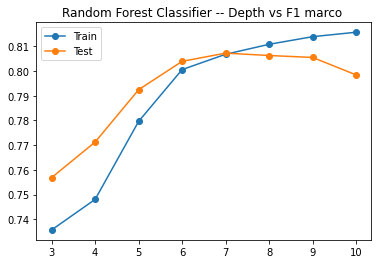

In [28]:

# define the tree depths to evaluate
values = [3, 4, 5, 6, 7, 8, 9, 10]
train_scores, test_scores = list(), list()
# evaluate a decision tree for each depth
for i in values:
  # configure the model
  model = Pipeline(steps=[('c', SMOTETomek(random_state=0)),('m',
                                                             RandomForestClassifier(n_jobs=-1,
                                                                                    max_depth=i, 
                                                                                    n_estimators= 100, 
                                                                                    criterion = "log_loss", 
                                                                                    min_samples_split= 2, 
                                                                                    max_features= 5,
                                                                                    random_state=0))])
  # fit model on the training dataset
  model.fit(X_train, y_train)
  # evaluate on the train dataset
  train_yhat = model.predict(X_train)
  train_f1 = f1_score(y_train, train_yhat,average='macro')
  train_scores.append(train_f1)
  # evaluate on the test dataset
  test_yhat = model.predict(X_test)
  test_acc = f1_score(y_test, test_yhat,average='macro')
  test_scores.append(test_acc)
  # summarize progress
  print('>%d, train: %.3f, test: %.3f' % (i, train_f1, test_acc))
# plot of train and test scores vs tree depth
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.title("Random Forest Classifier -- Depth vs F1 marco ")
pyplot.legend()
pyplot.show()

# XGboost

>3, train: 0.801, test: 0.795
>4, train: 0.809, test: 0.793
>5, train: 0.816, test: 0.791
>6, train: 0.822, test: 0.786
>7, train: 0.827, test: 0.780
>8, train: 0.834, test: 0.780
>9, train: 0.843, test: 0.773
>10, train: 0.848, test: 0.770


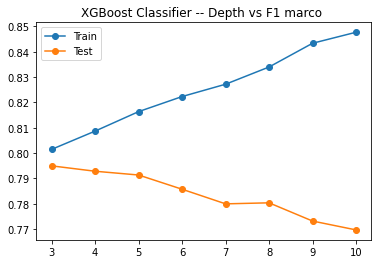

In [29]:
from matplotlib import pyplot
from imblearn.pipeline import Pipeline
# define the tree depths to evaluate
values = [3, 4, 5, 6, 7, 8, 9, 10]
train_scores, test_scores = list(), list()
# evaluate a decision tree for each depth
for i in values:
  # configure the model
  model = Pipeline(steps=[('c', SMOTETomek(random_state=0)),('m',
                 XGBClassifier(n_jobs=-1,
                                        learning_rate=0.15, 
                                        max_depth = i, 
                                        min_child_weight = 3, 
                                        colsample_bytree= 0.3, 
                                        n_estimators = 200,))])
  # fit model on the training dataset
  model.fit(X_train, y_train)
  # evaluate on the train dataset
  train_yhat = model.predict(X_train)
  train_f1 = f1_score(y_train, train_yhat,average='macro')
  train_scores.append(train_f1)
  # evaluate on the test dataset
  test_yhat = model.predict(X_test)
  test_acc = f1_score(y_test, test_yhat,average='macro')
  test_scores.append(test_acc)
  # summarize progress
  print('>%d, train: %.3f, test: %.3f' % (i, train_f1, test_acc))
# plot of train and test scores vs tree depth
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.title("XGBoost Classifier -- Depth vs F1 marco ")
pyplot.legend()
pyplot.show()

# 1.6. Comparative study

In [30]:
#Random Forest Best paramn testing
pipeline = Pipeline(steps=[('c', SMOTETomek()),
                ('m',
                 RandomForestClassifier(n_jobs=-1,
                                        max_depth=7, 
                                        n_estimators= 100, 
                                        criterion = "log_loss", 
                                        min_samples_split= 2, 
                                        max_features= 5,
                                        ))])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

  
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.54      0.65      0.59       226
           1       0.98      0.99      0.99      2649
           2       0.90      0.79      0.85       568

    accuracy                           0.94      3443
   macro avg       0.81      0.81      0.81      3443
weighted avg       0.94      0.94      0.94      3443



In [31]:
#XGboost Best paramn testing
pipeline = Pipeline(steps=[('c', SMOTETomek()),
                ('m',
                 XGBClassifier(n_jobs=-1,
                                        learning_rate=0.15, 
                                        max_depth = 7, 
                                        min_child_weight = 3, 
                                        colsample_bytree= 0.3, 
                                        n_estimators = 200,
                                        ))])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

  
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.47      0.60      0.53       226
           1       0.98      0.98      0.98      2649
           2       0.87      0.80      0.83       568

    accuracy                           0.92      3443
   macro avg       0.78      0.79      0.78      3443
weighted avg       0.93      0.92      0.93      3443



# 1.7. Test Case Prediction

In [32]:
#Test Case Prediction using Ranodm Forest best Param
pipeline = Pipeline(steps=[('c', SMOTETomek()),
                ('m',
                 RandomForestClassifier(n_jobs=-1,
                                        max_depth=7, 
                                        n_estimators= 100, 
                                        criterion = "log_loss", 
                                        min_samples_split= 2, 
                                        max_features= 5,
                                        ))])
pipeline.fit(X_train, y_train)
y_preds = pipeline.predict(test)

In [33]:
y_preds.shape

(4304,)

In [34]:
def create_submission_file(y_preds, file_name):
  with open(file_name, 'w') as csvfile:
    wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
    wr.writerow(["Id", "Prediction"])
    for i, pred in enumerate(y_preds):
      wr.writerow([str(i), str(pred)])

create_submission_file(y_preds, "submission_random_forest.csv")

In [35]:
y_preds

array([0, 1, 1, ..., 1, 1, 1])